# **<center> CHE1125 - Homework 6 </center>**

### **<center> Abhishek Patel </center>**

In [1]:
import cobra
import straindesign as sd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging

from tqdm import tqdm
from scipy.integrate import solve_ivp

In [2]:
ecc = cobra.io.load_model('e_coli_core')

# 1. Find a knockouts strategy, using E. coli core model, that couples acetate production with growth. Set the maximum number of knockouts to 7. Plot the production envelope (plot of growth vs acetate production).

### Remember that your target reaction should be the export reaction for the corresponding metabolite. For your answers, include the phenotypic phase plane that compares the wild-type to the mutant strain and a table with the knockouts.

In [3]:
module_suppress = sd.SDModule(ecc, sd.names.SUPPRESS, constraints = 'EX_ac_e + 0.3 EX_glc__D_e <= 0')
module_protect  = sd.SDModule(ecc, sd.names.PROTECT, constraints = 'BIOMASS_Ecoli_core_w_GAM >= 0.2')

In [4]:
logging.basicConfig(level=logging.INFO)
# Compute strain designs
sols = sd.compute_strain_designs(ecc,
                                 sd_modules = [module_suppress, module_protect],
                                 time_limit = 369,
                                 max_solutions = 1,
                                 max_cost = 7,
                                 solution_approach = sd.names.ANY)
# Print solutions
print(f"One compressed solution with cost {sols.sd_cost[0]} found and "+\
      f"expanded to {len(sols.reaction_sd)} solutions in the uncompressed netork.")
print(f"Example knockout set: {[s for s in sols.reaction_sd[0]]}")

INFO:root:Preparing strain design computation.
INFO:root:  Using glpk for solving LPs during preprocessing.
INFO:root:  FVA to identify blocked reactions and irreversibilities.
INFO:root:  FVA(s) to identify essential reactions.
INFO:root:Compressing Network (95 reactions).
INFO:root:  Removing blocked reactions.
INFO:root:  Translating stoichiometric coefficients to rationals.
INFO:root:  Removing conservation relations.
INFO:root:  Compression 1: Applying compression from EFM-tool module.
INFO:root:  Reduced to 56 reactions.
INFO:root:  Compression 2: Lumping parallel reactions.
INFO:root:  Last step could not reduce size further (56 reactions).
INFO:root:  Network compression completed. (1 compression iterations)
INFO:root:  Translating stoichiometric coefficients back to float.
INFO:root:  FVA(s) in compressed model to identify essential reactions.
INFO:root:Finished preprocessing:
INFO:root:  Model size: 56 reactions, 33 metabolites
INFO:root:  45 targetable reactions
INFO:root:Co

One compressed solution with cost 4.0 found and expanded to 2 solutions in the uncompressed netork.
Example knockout set: ['PYK', 'ME1', 'NADTRHD', 'EX_h2o_e']


In [5]:
pd.DataFrame(sols.reaction_sd)

,PYK,ME1,NADTRHD,EX_h2o_e,H2Ot
0,-1.0,-1.0,-1.0,-1.0,NaN
1,-1.0,-1.0,-1.0,NaN,-1.0


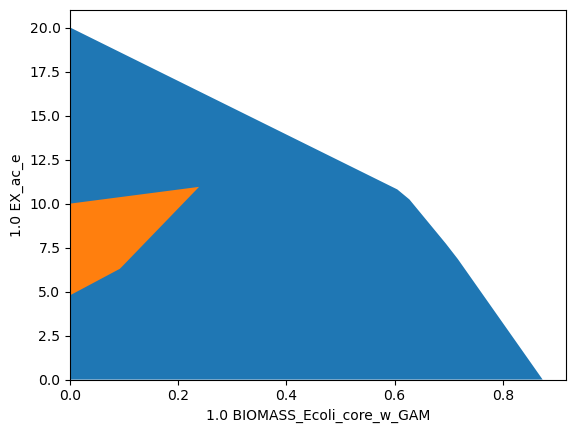

In [6]:
# Wild-type plot
datapoints, triang, plot1 = sd.plot_flux_space(ecc,
                                              ('BIOMASS_Ecoli_core_w_GAM', ('EX_ac_e')),
                                              show = False);

knockouts = [[{s:1.0}, '=', 0.0] for s in sols.reaction_sd[0]]
# knockouts = ['PYK = 0', 'ME1 = 0', 'NADTRHD = 0', 'EX_h2o_e = 0']

_,          _,      plot2 = sd.plot_flux_space(ecc,
                                              ('BIOMASS_Ecoli_core_w_GAM', ('EX_ac_e')),
                                              constraints = knockouts,
                                              show = False);
# adjust axes limits and show plot
plot2.axes.set_xlim(0, 1.05 * max([a[0] for a in datapoints]))
plot2.axes.set_ylim(0, 1.05 * max([a[1] for a in datapoints]))
plt.show()

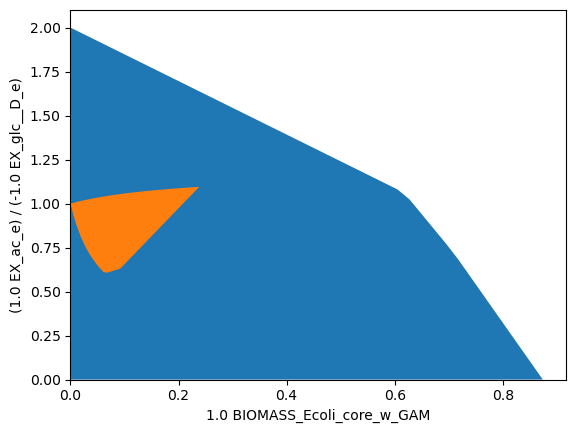

In [7]:
# Wild-type plot
datapoints, triang, plot1 = sd.plot_flux_space(ecc,
                                              ('BIOMASS_Ecoli_core_w_GAM', ('EX_ac_e', '-EX_glc__D_e')),
                                              show = False);

knockouts = [[{s:1.0}, '=', 0.0] for s in sols.reaction_sd[0]]
# knockouts = ['PYK = 0', 'ME1 = 0', 'NADTRHD = 0', 'EX_h2o_e = 0']

_,          _,      plot2 = sd.plot_flux_space(ecc,
                                              ('BIOMASS_Ecoli_core_w_GAM', ('EX_ac_e', '-EX_glc__D_e')),
                                              constraints = knockouts,
                                              show = False);
# adjust axes limits and show plot
plot2.axes.set_xlim(0, 1.05 * max([a[0] for a in datapoints]))
plot2.axes.set_ylim(0, 1.05 * max([a[1] for a in datapoints]))
plt.show()

# 2. Right after performing the KOs in vivo you realize that your strain’s phenotype differs significantly from the prediction of FBA. 
### Why could that be the case?

Lets run FBA on the Model:

In [8]:
ecc = cobra.io.load_model('e_coli_core')

INFO:cobra.core.model:The current solver interface glpk doesn't support setting the optimality tolerance.


In [9]:
fba_result = ecc.optimize()
fba_biomass = fba_result.objective_value
fba_ac = fba_result.fluxes['EX_ac_e']

# print(f"The Growth of the new strain is", fba_result)
print(f"The Growth rate of the new strain is", fba_biomass)
print(f"The Flux of Acetate of the new strain is", fba_ac)

The Growth rate of the new strain is 0.8739215069684295
The Flux of Acetate of the new strain is 0.0


In [10]:
for s in sols.reaction_sd[0]:
        ecc.reactions.get_by_id(s).knock_out()

In [11]:
fba_result = ecc.optimize()
fba_biomass = fba_result.objective_value
fba_ac = fba_result.fluxes['EX_ac_e']

# print(f"The Growth of the new strain is", fba_result)
print(f"The Growth rate of the new strain is", fba_biomass)
print(f"The Flux of Acetate of the new strain is", fba_ac)

The Growth rate of the new strain is 0.23828066506723555
The Flux of Acetate of the new strain is 10.950477744886749


**Based on the 2 FBA results, the growth of the new strain has decreased when compared to the Wild Type. This could be because of many reasons.**

**`The steady-state assumption in FBA may not fully capture the dynamic nature of cellular processes, and the reliance on gene-protein-reaction associations might overlook post-transcriptional and post-translational regulatory mechanisms.`**

**`Model incompleteness or inaccuracies, introduced during model compression and simplification steps, could contribute to discrepancies.`**

**`Environmental conditions, biological complexity, and the lack of consideration for genetic regulation also play roles.`**

**`Additionally, the inherent variability in biological experiments can influence the observed phenotype.`**

**`A factor could've also been that, during model compression, a reaction may have been compressed/deleted that would increase growth.`**

***To improve predictive accuracy, it is essential to validate the metabolic model against experimental data, consider dynamic simulation approaches, explore more detailed models with regulatory elements, and conduct further experiments for validation and refinement. The integration of computational modeling and experimental validation is crucial for a more comprehensive understanding of the system.***

# 3. Using ROOM or MOMA, predict the growth rates and product fluxes for any ONE deletion strategy predicted by MCS. 
### Attach a phenotypic phase plane showing the operating point predicted by FBA and MOMA or ROOM.

### MOMA

INFO:cobra.core.model:The current solver interface glpk doesn't support setting the optimality tolerance.


Growth rate predicted by FBA:  0.23828066506722476
Acetate flux predicted by FBA:  10.950477744886584
Growth rate predicted by MOMA  0.1286715655366243
Acetate flux predicted by MOMA:  8.118629576168344
According to FVA, the minimum is  10.9504777448867 and the maximum is 10.950477744886667


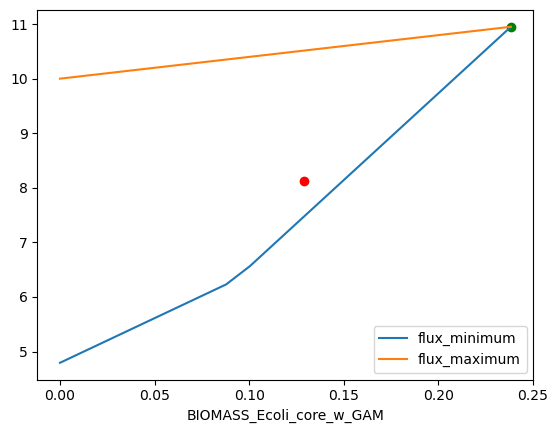

In [12]:
ecc = cobra.io.load_model('e_coli_core')
with ecc:
    ref_flux = ecc.optimize()
    for s in sols.reaction_sd[0]:
        ecc.reactions.get_by_id(s).knock_out()
    moma_result = cobra.flux_analysis.moma(model = ecc, solution = ref_flux)
    fba_result = ecc.optimize()
    fba_biomass = fba_result.objective_value
    fba_ac = fba_result.fluxes['EX_ac_e']
    moma_biomass = moma_result.fluxes['BIOMASS_Ecoli_core_w_GAM']
    moma_ac = moma_result.fluxes['EX_ac_e']
    prod_env = cobra.flux_analysis.production_envelope(ecc, ["BIOMASS_Ecoli_core_w_GAM"], objective = "EX_ac_e", carbon_sources = "EX_glc__D_e")
    prod_env.plot(kind = 'line', x = 'BIOMASS_Ecoli_core_w_GAM', y = ['flux_minimum','flux_maximum']);
    
    plt.scatter(fba_biomass, fba_ac, c = 'green')
    plt.scatter(moma_biomass,moma_ac, c = "red")
    print("Growth rate predicted by FBA: ", fba_biomass)
    print("Acetate flux predicted by FBA: ", fba_ac)
    print("Growth rate predicted by MOMA ", moma_biomass)
    print("Acetate flux predicted by MOMA: ", moma_ac)
    fva_result = cobra.flux_analysis.flux_variability_analysis(ecc, ecc.reactions, fraction_of_optimum = 1)
    print("According to FVA, the minimum is ", fva_result['minimum']["EX_ac_e"], "and the maximum is", fva_result['maximum']["EX_ac_e"])

### ROOM

INFO:cobra.core.model:The current solver interface glpk doesn't support setting the optimality tolerance.


Growth rate predicted by FBA:  0.23828066506722476
Acetate flux predicted by FBA:  10.950477744886584
Growth rate predicted by ROOM  0.08469934270887966
Acetate flux predicted by ROOM:  6.291198723272688


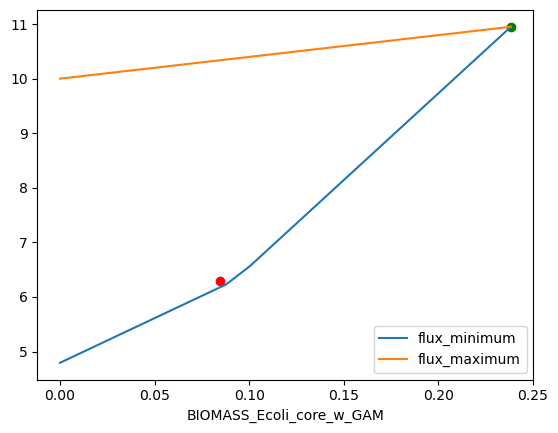

In [13]:
ecc = cobra.io.load_model('e_coli_core')
with ecc:
    for reaction in ecc.reactions: # Will run forever without this
        if reaction.upper_bound == 1000:
            reaction.upper_bound = 99999999
        if reaction.lower_bound == -1000:
            reaction.lower_bound = -99999999
    ref_flux = ecc.optimize()
    for s in sols.reaction_sd[0]:
        ecc.reactions.get_by_id(s).knock_out()
    room_result = cobra.flux_analysis.room(model = ecc, solution = ref_flux, linear = 0)
    fba_result = ecc.optimize()
    fba_biomass = fba_result.objective_value
    fba_ac = fba_result.fluxes['EX_ac_e']
    room_biomass = room_result.fluxes['BIOMASS_Ecoli_core_w_GAM']
    room_ac = room_result.fluxes['EX_ac_e']
    prod_env = cobra.flux_analysis.production_envelope(ecc, ["BIOMASS_Ecoli_core_w_GAM"], objective = "EX_ac_e", carbon_sources = "EX_glc__D_e")
    prod_env.plot(kind = 'line', x = 'BIOMASS_Ecoli_core_w_GAM', y = ['flux_minimum','flux_maximum']);
    
    plt.scatter(fba_biomass, fba_ac, c = 'green')
    plt.scatter(room_biomass,room_ac, c = "red")
    print("Growth rate predicted by FBA: ", fba_biomass)
    print("Acetate flux predicted by FBA: ", fba_ac)
    print("Growth rate predicted by ROOM ", room_biomass)
    print("Acetate flux predicted by ROOM: ", room_ac)

# 4. Using dFBA, plot the acetate production over time of your new mutant strain. Assume that you initially have 0.1 g/L of biomass and 10g/L of glucose. 
### The plot should contain biomass and acetate concentration.

In [14]:
for s in sols.reaction_sd[0]:
        ecc.reactions.get_by_id(s).knock_out()

In [15]:
def add_dynamic_bounds(model, y):
    """Use external concentrations to bound the uptake flux of glucose."""
    biomass, glucose = y  # expand the boundary species
    glucose_max_import = -10 * glucose / (5 + glucose)
    model.reactions.EX_glc__D_e.lower_bound = glucose_max_import


def dynamic_system(t, y):
    """Calculate the time derivative of external species."""

    biomass, glucose = y  # expand the boundary species

    # Calculate the specific exchanges fluxes at the given external concentrations.
    with model:
        add_dynamic_bounds(model, y)

        cobra.util.add_lp_feasibility(model)
        feasibility = cobra.util.fix_objective_as_constraint(model)
        lex_constraints = cobra.util.add_lexicographic_constraints(
            model, ['BIOMASS_Ecoli_core_w_GAM', 'EX_ac_e'], ['max', 'max']) # Enter name of biomass ID

    # Since the calculated fluxes are specific rates, we multiply them by the
    # biomass concentration to get the bulk exchange rates.
    fluxes = lex_constraints.values
    fluxes *= biomass

    # This implementation is **not** efficient, so I display the current
    # simulation time using a progress bar.
    if dynamic_system.pbar is not None:
        dynamic_system.pbar.update(1)
        dynamic_system.pbar.set_description('t = {:.3f}'.format(t))

    return fluxes

dynamic_system.pbar = None


def infeasible_event(t, y):
    """
    Determine solution feasibility.

    Avoiding infeasible solutions is handled by solve_ivp's built-in event detection.
    This function re-solves the LP to determine whether or not the solution is feasible
    (and if not, how far it is from feasibility). When the sign of this function changes
    from -epsilon to positive, we know the solution is no longer feasible.

    """

    with model:

        add_dynamic_bounds(model, y)

        cobra.util.add_lp_feasibility(model)
        feasibility = cobra.util.fix_objective_as_constraint(model)

    return feasibility - infeasible_event.epsilon

infeasible_event.epsilon = 1E-6
infeasible_event.direction = 1
infeasible_event.terminal = True

In [16]:
model = ecc 
ts = np.linspace(0, 40, 10)  # Desired integration resolution and interval, here its 15h with 100 interval
y0 = [0.1, 10] # This is initial biomass and glucose concentration, respectively

with tqdm() as pbar:
    dynamic_system.pbar = pbar

    sol = solve_ivp(
                    fun = dynamic_system,
                    events = [infeasible_event],
                    t_span = (ts.min(), ts.max()),
                    y0 = y0,
                    t_eval = ts,
                    rtol = 1e-6,
                    atol = 1e-8,
                    method = 'BDF'
                    )
    
sol

t = 40.000: : 185it [00:24,  7.43it/s]


  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  4.444e+00  8.889e+00  1.333e+01  1.778e+01
             2.222e+01  2.667e+01  3.111e+01  3.556e+01  4.000e+01]
        y: [[ 1.000e-01  1.574e-01 ...  9.149e+01  2.634e+02]
            [ 1.000e+01  1.414e+01 ...  4.236e+03  1.214e+04]]
      sol: None
 t_events: [array([], dtype=float64)]
 y_events: [array([], dtype=float64)]
     nfev: 182
     njev: 1
      nlu: 19

Text(0, 0.5, 'Acetate')

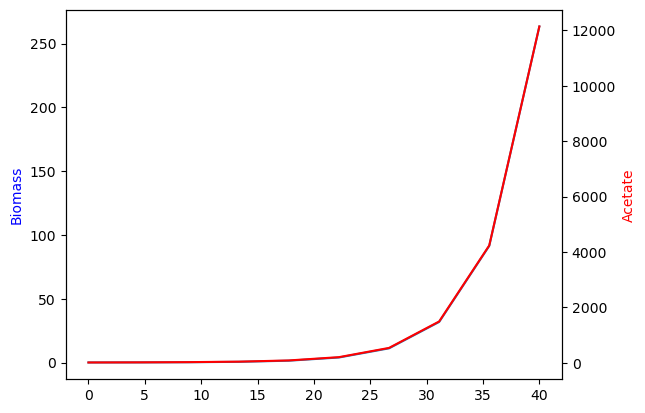

In [17]:
ax = plt.subplot(111)
ax.plot(sol.t, sol.y.T[:, 0])
ax2 = plt.twinx(ax)
ax2.plot(sol.t, sol.y.T[:, 1], color='r')

ax.set_ylabel('Biomass', color='b')
ax2.set_ylabel('Acetate', color='r')

In [18]:
model = ecc 
ts = np.linspace(30, 40, 20)  # Desired integration resolution and interval, here its 15h with 100 interval
y0 = [0.1, 10] # This is initial biomass and glucose concentration, respectively

with tqdm() as pbar:
    dynamic_system.pbar = pbar

    sol = solve_ivp(
                    fun = dynamic_system,
                    events = [infeasible_event],
                    t_span = (ts.min(), ts.max()),
                    y0 = y0,
                    t_eval = ts,
                    rtol = 1e-6,
                    atol = 1e-8,
                    method = 'BDF'
                    )
    
sol

t = 40.000: : 67it [00:09,  7.30it/s]


  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 3.000e+01  3.053e+01 ...  3.947e+01  4.000e+01]
        y: [[ 1.000e-01  1.047e-01 ...  3.158e-01  3.436e-01]
            [ 1.000e+01  1.038e+01 ...  2.363e+01  2.518e+01]]
      sol: None
 t_events: [array([], dtype=float64)]
 y_events: [array([], dtype=float64)]
     nfev: 64
     njev: 1
      nlu: 9

Text(0, 0.5, 'Acetate')

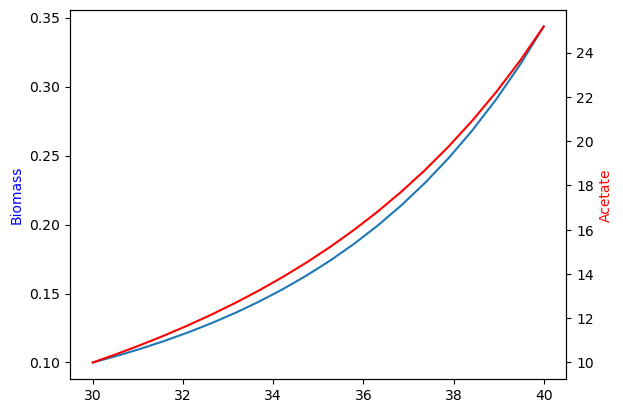

In [19]:
ax = plt.subplot(111)
ax.plot(sol.t, sol.y.T[:, 0])
ax2 = plt.twinx(ax)
ax2.plot(sol.t, sol.y.T[:, 1], color='r')

ax.set_ylabel('Biomass', color='b')
ax2.set_ylabel('Acetate', color='r')